In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [4]:
#fetch historical data using yfinance
def get_stock_data(ticker,start='2022-01-01',end='2024-01-01'):
    data=yf.download(ticker,start=start,end=end)
    data=data[['Close','Volume']]
    data.rename(columns={'Close':'Close'},inplace=True)
    return data

In [6]:
#calculate moving averages
def calculate_moving_averages(data, short_window, long_window):
    data['Short_MA']=data['Close'].rolling(window=short_window,min_periods=1).mean()
    data['Long_MA']=data['Close'].rolling(window=long_window,min_periods=1).mean()
    return data

In [7]:
#calculate RSI
def calculate_rsi(data, period=14):
    delta=data['Close'].diff()
    gain=(delta.where(delta>0,0)).rolling(window=period).mean()
    loss=(-delta.where(delta<0,0)).rolling(window=period).mean()
    rs = gain / loss
    data['RSI'] =100-(100/(1 + rs))
    return data

In [8]:
# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window=12,long_window=26,signal_window=9):
    data['Short_EMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()# short-term EMA (default is 12)
    data['Long_EMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()#long-term EMA (default is 26)
    data['MACD_Line'] = data['Short_EMA'] - data['Long_EMA']
    data['Signal_Line'] = data['MACD_Line'].ewm(span=signal_window, adjust=False).mean()# signal line EMA (default is 9)
    data['MACD_Histogram'] = data['MACD_Line'] - data['Signal_Line']
    return data


In [9]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_sd=2):
    data['Moving_Avg']=data['Close'].rolling(window=window).mean()
    data['Std_Dev']=data['Close'].rolling(window=window).std()
    data['Upper_Band']=data['Moving_Avg']+(data['Std_Dev'] * num_sd)
    data['Lower_Band']=data['Moving_Avg']-(data['Std_Dev'] * num_sd)
    return data

In [11]:
# Generate Buy/Sell Signals
def generate_signals(data):
    data['Signal'] = 0
    data.loc[(data['Short_MA']>data['Long_MA']) & (data['RSI'] < 40),'Signal']=1 # Buy
    data.loc[(data['Short_MA']<data['Long_MA']) & (data['RSI'] > 60),'Signal']=-1  # Sell
    data['Position'] = data['Signal'].diff()
    return data

In [17]:
#prepare data for ml
def prepare_ml_data(data):
    data['Target'] = data['Position'].shift(-5).fillna(0)# #create the target variable by shifting the Position column 5 rows back.
    #this essentially sets the target as the future position (buy/sell/hold) 5 steps ahead.
    # -1 →class 0,0 → class1,1 → class2.
    data['Target'] = data['Target'].map({-1: 0, 0: 1, 1: 2})
    features = ['Short_MA', 'Long_MA', 'RSI', 'MACD_Line', 'Signal_Line',
                'Upper_Band', 'Lower_Band', 'Volume']
    X = data[features].dropna()
    y = data.loc[X.index, 'Target']
    return X, y


In [19]:
#calculate portfolio performance
def calculate_portfolio_performance(data, initial_capital=100000, transaction_cost=0.001):
    data['Position'] = data['Signal'].shift()
    data['Daily_Return'] = data['Close'].pct_change()
    data['Strategy_Return']=data['Position']*data['Daily_Return']
    data['Strategy_Return']-=transaction_cost*abs(data['Position'].diff())
    data['Portfolio_Value'] = initial_capital*(1 + data['Strategy_Return'].fillna(0)).cumprod()
    return data, initial_capital, data['Portfolio_Value'].iloc[-1]

In [20]:
# Plot results
def plot_results(data, initial_capital, final_value):
    plt.figure(figsize=(14, 12))
    plt.subplot(4, 1, 1)
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data['Short_MA'], label='Short MA', color='red', alpha=0.75)
    plt.plot(data['Long_MA'], label='Long MA', color='green', alpha=0.75)
    plt.title(f'Portfolio Performance\nInitial: ${initial_capital} | Final: ${final_value:.2f}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [21]:

ticker='AAPL'
short_window=40
long_window=100

In [22]:

data=get_stock_data(ticker)
data=calculate_moving_averages(data,short_window,long_window)
data=calculate_rsi(data)
data=calculate_macd(data)
data=calculate_bollinger_bands(data)
data=generate_signals(data)

[*********************100%***********************]  1 of 1 completed


In [23]:
print(data)

Price                           Close     Volume    Short_MA     Long_MA  \
Ticker                           AAPL       AAPL                           
Date                                                                       
2022-01-03 00:00:00+00:00  182.009995  104487900  182.009995  182.009995   
2022-01-04 00:00:00+00:00  179.699997   99310400  180.854996  180.854996   
2022-01-05 00:00:00+00:00  174.919998   94537600  178.876663  178.876663   
2022-01-06 00:00:00+00:00  172.000000   96904000  177.157497  177.157497   
2022-01-07 00:00:00+00:00  172.169998   86709100  176.159998  176.159998   
...                               ...        ...         ...         ...   
2023-12-22 00:00:00+00:00  193.600006   37122800  188.165250  181.768301   
2023-12-26 00:00:00+00:00  193.050003   28919300  188.786000  181.787101   
2023-12-27 00:00:00+00:00  193.149994   48087700  189.357500  181.898701   
2023-12-28 00:00:00+00:00  193.580002   34049900  189.927750  182.046001   
2023-12-29 0

In [24]:

X,y=prepare_ml_data(data)
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [26]:
print(X_train)

[[ 0.59406213  0.77543899 -0.1594043  ...  0.57034055  0.29364466
   0.79059188]
 [-1.04406795 -0.62246876 -0.3593541  ... -0.82784472 -0.95014136
   0.17059037]
 [-0.1475851  -0.94893269 -0.21901333 ... -0.20413849  0.44198922
  -1.07594905]
 ...
 [ 0.91099644  0.23067542  0.85232284 ...  1.049681    1.05225355
  -0.90523348]
 [ 1.04371727  1.70816757 -0.25745329 ...  0.62263441  0.94013618
  -1.14744143]
 [-1.09832278 -0.2055875  -0.98800975 ... -1.11202262 -1.4125963
  -0.15861796]]


In [27]:
models = {
    'Logistic Regression':LogisticRegression(max_iter=1000),
    'Random Forest':RandomForestClassifier(n_estimators=100),
    'XGBoost':XGBClassifier(eval_metric='mlogloss')
}

In [28]:
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(f"{name} Accuracy:", accuracy_score(y_test, predictions))
        print(classification_report(y_test, predictions))
    except ValueError as e:
        print(f"Error with {name}: {e}")

Logistic Regression Accuracy: 0.9103448275862069
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95       132
           2       0.00      0.00      0.00         6

    accuracy                           0.91       145
   macro avg       0.30      0.33      0.32       145
weighted avg       0.83      0.91      0.87       145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Accuracy: 0.8896551724137931
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.98      0.94       132
           2       0.00      0.00      0.00         6

    accuracy                           0.89       145
   macro avg       0.30      0.33      0.31       145
weighted avg       0.83      0.89      0.86       145

XGBoost Accuracy: 0.8827586206896552
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      0.97      0.94       132
           2       0.00      0.00      0.00         6

    accuracy                           0.88       145
   macro avg       0.30      0.32      0.31       145
weighted avg       0.83      0.88      0.86       145



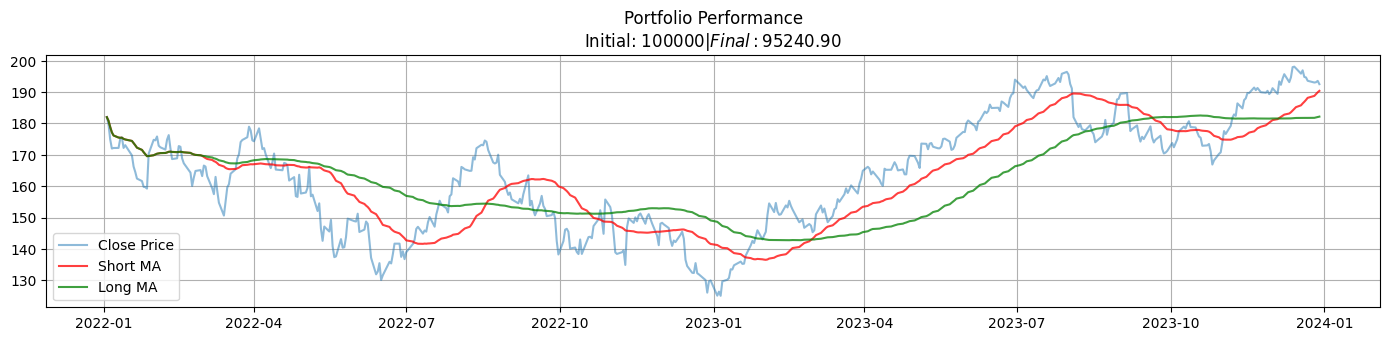

In [29]:
data,initial_capital,final_value=calculate_portfolio_performance(data)
plot_results(data,initial_capital,final_value)
